# `Python`模式水平验证函数
## 处理`WRF-Chem`模式数据结果

---
*@author: Evan*\
*@date: 2022-08-05*

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import scipy.io as io
import math
import sklearn

from matplotlib import pyplot as plt

In [3]:
# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 1.读取数据
### 1.1模拟数据

* 使用Matlab查看格点与经纬度对照
    * chemFile='F:\Data\case_GZtransport\GZtran_chem_base_d03.nc'
    * lat=ncread(chemFile,'XLAT');
    * lat=squeeze(lat(:,:,1));
    * lon=ncread(chemFile,'XLONG');
    * lon=squeeze(lon(:,:,1));

In [4]:
# obeservation sites
xyloc=[['广雅中学',29,69,23.1422,113.2350,344],['市五中',32,65,23.105,113.261,345],['天河职幼',37,68,23.1358,113.3170,346],
       ['广东商学院',41,64,23.0916,113.348,347],['市监测站',32,68,23.1331,113.26,351],['麓湖',34,71,23.1569,113.281,353],
       ['体育西',38,68,23.1323,113.3208,1500],['市八十六中',49,65,23.105,113.433,348],['番禺中学',41,48,22.9477,113.352,349],
       ['花都师范',27,96,23.3917,113.215,350],['九龙镇镇龙',62,84,23.2783,113.5680,352],['帽峰山森林公园',65,114,23.5538,113.589,354]]
df=pd.DataFrame(xyloc,columns=['Name','xloc','yloc','lat(°N)','lon(°E)','nsite'])
df

,Name,xloc,yloc,lat(°N),lon(°E),nsite
0,广雅中学,29,69,23.1422,113.2350,344
1,市五中,32,65,23.1050,113.2610,345
2,天河职幼,37,68,23.1358,113.3170,346
3,广东商学院,41,64,23.0916,113.3480,347
4,市监测站,32,68,23.1331,113.2600,351
5,麓湖,34,71,23.1569,113.2810,353
6,体育西,38,68,23.1323,113.3208,1500
7,市八十六中,49,65,23.1050,113.4330,348
8,番禺中学,41,48,22.9477,113.3520,349
9,花都师范,27,96,23.3917,113.2150,350


In [5]:
# find xyloc in grid d03 from dataframe
loc_index = df[df.Name=='市监测站'].index
nlat=df.iloc[loc_index].xloc
nlon=df.iloc[loc_index].yloc
nsite=df.iloc[loc_index].nsite

def get_var(filepath,varname):
    '''
    get varname(only one layer) from filepath
    convert UTC time to local time
    '''
    ncfile=nc.Dataset(filepath)
    var=ncfile.variables[varname][:]
    tstep=np.size(var,0)
    var_L1=np.squeeze(var[(72-8):(tstep-9),nlat,nlon]) #L1=1000hPa
    print(varname,' = ',var_L1.shape)
    return(var_L1)

def get_var1(filepath,varname):
    '''
    get varname(on layer 0) from filepath
    convert UTC time to local time
    '''
    ncfile=nc.Dataset(filepath)
    var=ncfile.variables[varname][:]
    tstep=np.size(var,0)
    var_L1=np.squeeze(var[(72-8):(tstep-9),0,nlat,nlon]) #L1=1000hPa
    print(varname,' = ',var_L1.shape)
    return(var_L1)

In [29]:
chempath='F:/Data/case_GZtransport/GZtran_chem_base_d03.nc'
metpath='F:/Data/case_GZtransport/GZtran_met_base_d03.nc'

### 1.2观测数据

In [7]:
headname=['year','month','day','hour','temp','dew point','SLP','WD','WS','cloud','1h-rain','6h-rain']
df_obs=pd.read_csv('F:/Data/case_GZtransport/observation/592870-99999-2021.csv',delim_whitespace = True,header=0,
                    nrows=168).replace(-9999,np.nan)
df_obs

,year,month,day,hour,temp,dew_point,SLP,WD,WS,cloud,1h-rain,6h-rain
0,2021,4,17,16,230,170,NaN,360.0,30,NaN,NaN,NaN
1,2021,4,17,17,220,170,NaN,NaN,10,NaN,NaN,NaN
2,2021,4,17,18,207,185,10160.0,347.0,20,NaN,NaN,NaN
3,2021,4,17,19,220,180,NaN,80.0,10,NaN,NaN,NaN
4,2021,4,17,20,220,180,NaN,100.0,20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021,4,24,11,290,210,NaN,160.0,60,NaN,NaN,NaN
164,2021,4,24,12,262,209,10094.0,154.0,30,NaN,NaN,NaN
165,2021,4,24,13,270,210,NaN,150.0,60,NaN,NaN,NaN
166,2021,4,24,14,270,210,NaN,170.0,50,NaN,NaN,NaN


In [37]:
# Suface Pressure
var=get_var(metpath,'PSFC')
var=var[2:len(var):3]/100 # PSFC,units:hPa
print('notnan=',var.shape)

var_o=df_obs['SLP']/10
var_obs=var_o[2:len(var_o):3]

PSFC  =  (168,)
notnan= (56,)


In [41]:
# Temperature at 2m
var=get_var(metpath,'T2')
var=var-273.15 # T2,units:°C

var_obs=df_obs['temp']/10

T2  =  (168,)


In [45]:
# Relative Humidity
T=get_var(metpath,'T2')-273.15 
q=get_var(metpath,'Q2')
P=get_var(metpath,'PSFC')

E=6.112*np.exp((17.67*T)/(T+243.5)) # 饱和水汽压
e=q*(P/100)/0.622 # 实际水汽压
RH=e/E*100 # (%)
var=RH

To=df_obs['temp']/10
Td=df_obs['dew_point']/10
Eo=6.112*np.exp((17.67*To)/(To+243.5)) # 饱和水汽压
eo=6.112*np.exp((17.67*Td)/(Td+243.5)) # 实际水汽压
var_obs=eo/Eo*100 # (%)

T2  =  (168,)
Q2  =  (168,)
PSFC  =  (168,)


In [38]:
# Wind Speed at 10m
var1=get_var(metpath,'U10')
var2=get_var(metpath,'V10')
var=np.sqrt(var1**2+var2**2) # wind,units:m/s

var_obs=df_obs['WS']/10

U10  =  (168,)
V10  =  (168,)


In [39]:
n=0
for i in range(0,len(var_obs)):
    if np.isnan(var_obs[i])==True:
        if i>=1:
            print(i-1,var_obs[i-1])
        print(i,var_obs[i])
        if i<=166:
            print(i+1,var_obs[i+1])
        print('--------------')
        n=n+1
print('共有',n,'个空值')

共有 0 个空值


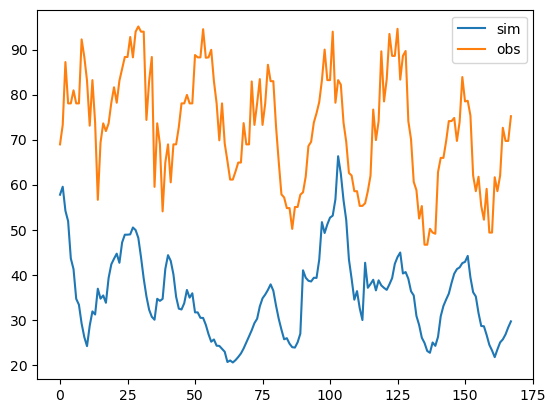

In [46]:
df_var=pd.DataFrame({'sim':var,
                'obs':var_obs})
df_var.plot()
plt.show()

---

In [10]:
# 平均值
# print('obs_average=',np.nanmean(var_obs),'ug/m-3')
# print('sim_average=',np.nanmean(var),'ug/m-3')

# 相关系数
# df_var.corr().iloc[0,1]

# 平均偏差
# print(df_var.mad())
# print('sim-obs = ',df_var.mad()[0]-df_var.mad()[1])

# 均方根误差
# method 1
def get_mse(records_real, records_predict):
    """
    均方误差
    """
    if len(records_real) == len(records_predict):
        return sum([(x - y) ** 2 for x, y in zip(records_real, records_predict)]) / len(records_real)
    else:
        return None

def get_rmse(records_real, records_predict):
    """
    均方根误差
    """
    mse = get_mse(records_real, records_predict)
    if mse:
        return math.sqrt(mse)
    else:
        return None

# method 2
# MSE=np.square(np.subtract(O3_obs,O3)).mean()
# RMSE=math.sqrt(MSE)

# 标准化平均误差
def get_nme(observe,predict):
    if len(observe) == len(predict):
        return sum([abs(x - y) for x, y in zip(observe, predict)]) / sum(observe)
    else:
        return None

# 标准化平均偏差
def get_nmb(observe,predict):
    if len(observe) == len(predict):
        return sum([(x - y) for x, y in zip(observe, predict)]) / sum(observe)
    else:
        return None

In [47]:
eval_data=[['观测平均',np.nanmean(var_obs)],
            ['模拟平均',np.nanmean(var)],
            ['相关系数',df_var.corr().iloc[0,1]],
            ['平均偏差',df_var.mad()[0]-df_var.mad()[1]],
            ['均方根误差',get_rmse(var_obs, var)],
            ['标准化平均误差',get_nme(var_obs,var)],
            ['标准化平均偏差',get_nmb(var_obs,var)]]
df_eval=pd.DataFrame(eval_data,columns=['参数','值'])
df_eval

,参数,值
0,观测平均,72.693871
1,模拟平均,35.511211
2,相关系数,0.465605
3,平均偏差,-2.827882
4,均方根误差,38.923238
5,标准化平均误差,0.511496
6,标准化平均偏差,0.511496
